In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
protocols = pd.read_csv('data/protocols_common')
nodules_pos = pd.read_csv('data/nodules_positions')
plan_instances = pd.read_csv('data/plan_instances')

In [3]:
len(protocols), len(plan_instances), len(nodules_pos)

(2911, 371425, 5293)

In [4]:
plan_instances.head(3)

,study_id,desc,z_mm,instance_uid,dcm_path
0,RLS5A09001KDC6-K00004273,Inspirat. Body 5.0 Inspirat.,1660.5,1.2.276.0.7230010.3.1.3.1417964692.10880.15687...,E:\data\For_Publication_v3\Dicom\RLAD31D006-12...
1,RLS5A09001KDC6-K00004273,Inspirat. Lung 5.0 Inspirat.,1660.5,1.2.276.0.7230010.3.1.3.1417964692.10880.15687...,E:\data\For_Publication_v3\Dicom\RLAD31D006-12...
2,RLS5A09001KDC6-K00004273,Inspirat. Body 1.0 Inspirat.,1660.5,1.2.276.0.7230010.3.1.3.1417964692.10880.15687...,E:\data\For_Publication_v3\Dicom\RLAD31D006-12...


In [5]:
plans = plan_instances[['study_id', 'instance_uid', 'z_mm', 'dcm_path']]
plans['IsLung'] = plan_instances['desc'].str.lower().str.contains('lung')
plans['IsBody'] = plan_instances['desc'].str.lower().str.contains('body')

In [6]:
plans['IsLung'].value_counts()

False    248555
True     122870
Name: IsLung, dtype: int64

In [7]:
unknow_plan_type = ~plans['IsLung'] & ~plans['IsBody']
studies_with_unknow_plan_type = plan_instances[unknow_plan_type]['study_id'].unique()
print(len(studies_with_unknow_plan_type))
plan_instances[unknow_plan_type]['desc'].value_counts()

4


Sft Tissue 0.5               1262
CTA 1.0 CE  CTA Vol. FC08     818
Pediatric 1.0   Vol.          721
Sft Tissue 5.0                 55
Name: desc, dtype: int64

In [8]:
plans.head(3)

,study_id,instance_uid,z_mm,dcm_path,IsLung,IsBody
0,RLS5A09001KDC6-K00004273,1.2.276.0.7230010.3.1.3.1417964692.10880.15687...,1660.5,E:\data\For_Publication_v3\Dicom\RLAD31D006-12...,False,True
1,RLS5A09001KDC6-K00004273,1.2.276.0.7230010.3.1.3.1417964692.10880.15687...,1660.5,E:\data\For_Publication_v3\Dicom\RLAD31D006-12...,True,False
2,RLS5A09001KDC6-K00004273,1.2.276.0.7230010.3.1.3.1417964692.10880.15687...,1660.5,E:\data\For_Publication_v3\Dicom\RLAD31D006-12...,False,True


In [9]:
nodules = pd.merge(nodules_pos, plans, how='left', left_on=['study_id', 'z'], right_on=['study_id', 'z_mm'])
nodules.drop(['accession_number', 'z_type', 'z_mm'], inplace=True, axis=1)
nodules.head(3)

,study_id,nodule_id,diameter,x,y,z,comment,decision,id,ml,type,instance_uid,dcm_path,IsLung,IsBody
0,RLS5A09001KDC6-K00008714,002,6.0,400.0,281.0,1698.3,неверный размер,confirmed_partially,СВЕ,False,м,1.2.276.0.7230010.3.1.3.1417964692.10880.15687...,E:\data\For_Publication_v3\Dicom\RLAD31D006-11...,False,True
1,RLS5A09001KDC6-K00008714,002,6.0,400.0,281.0,1698.3,неверный размер,confirmed_partially,СВЕ,False,м,1.2.276.0.7230010.3.1.3.1417964692.10880.15687...,E:\data\For_Publication_v3\Dicom\RLAD31D006-11...,True,False
2,RLS5A09001KDC6-K00008714,002,6.0,417.0,251.0,1632.7,"несовпадение типа (п), неверный размер",confirmed_partially,СВЕ,True,п,1.2.276.0.7230010.3.1.3.1417964692.10880.15687...,E:\data\For_Publication_v3\Dicom\RLAD31D006-11...,False,True


In [10]:
without_plan_instance = nodules['instance_uid'].isna()
studies_with_nodules_without_plan = nodules[without_plan_instance]['study_id'].unique()
print(len(nodules[without_plan_instance]), len(studies_with_nodules_without_plan))
nodules[without_plan_instance][:5]

1050 217


,study_id,nodule_id,diameter,x,y,z,comment,decision,id,ml,type,instance_uid,dcm_path,IsLung,IsBody
812,RLSDD01000005658,013,4.0,88.0,284.0,148.0,неверный размер,confirmed_partially,Виктор,False,с,NaN,NaN,NaN,NaN
815,RLSDD01000005658,006,8.0,423.0,301.0,1572.1,NaN,confirmed,Виктор,True,м,NaN,NaN,NaN,NaN
816,RLSDD01000005658,013,3.0,423.0,301.0,216.0,"несовпадение типа (м), неверный размер",confirmed_partially,Виктор,True,м,NaN,NaN,NaN,NaN
821,RLSDD01000005658,013,3.0,95.0,329.0,252.0,NaN,confirmed,Виктор,False,с,NaN,NaN,NaN,NaN
828,RLSDD01000005658,006,7.0,355.0,389.0,201.0,несовпадение типа (с),confirmed_partially,Виктор,True,с,NaN,NaN,NaN,NaN


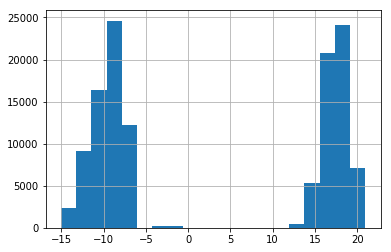

In [11]:
(plans[plans['IsLung']]['z_mm'] / 100).hist(bins=20)

In [12]:
studies_z_indexes = pd.DataFrame({'z_min': plans.groupby('study_id')['z_mm'].min(), 
                                  'z_max': plans.groupby('study_id')['z_mm'].max(),
                                  'z_median': plans.groupby('study_id')['z_mm'].median()})

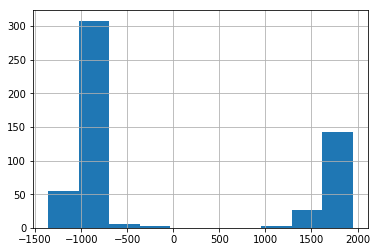

In [13]:
studies_z_indexes['z_median'].hist()

In [14]:
plans['HasNodules'] = plans['dcm_path'].isin(nodules['dcm_path']) 

In [15]:
plans.head()

,study_id,instance_uid,z_mm,dcm_path,IsLung,IsBody,HasNodules
0,RLS5A09001KDC6-K00004273,1.2.276.0.7230010.3.1.3.1417964692.10880.15687...,1660.5,E:\data\For_Publication_v3\Dicom\RLAD31D006-12...,False,True,False
1,RLS5A09001KDC6-K00004273,1.2.276.0.7230010.3.1.3.1417964692.10880.15687...,1660.5,E:\data\For_Publication_v3\Dicom\RLAD31D006-12...,True,False,False
2,RLS5A09001KDC6-K00004273,1.2.276.0.7230010.3.1.3.1417964692.10880.15687...,1660.5,E:\data\For_Publication_v3\Dicom\RLAD31D006-12...,False,True,False
3,RLS5A09001KDC6-K00004273,1.2.276.0.7230010.3.1.3.1417964692.10880.15687...,1660.5,E:\data\For_Publication_v3\Dicom\RLAD31D006-12...,True,False,False
4,RLS5A09001KDC6-K00004273,1.2.276.0.7230010.3.1.3.1417964692.10880.15687...,1661.3,E:\data\For_Publication_v3\Dicom\RLAD31D006-12...,False,True,False


In [16]:
plans_with_z = pd.merge(plans, studies_z_indexes, how='left', left_on='study_id', right_index=True)
nodules_with_z = pd.merge(nodules, studies_z_indexes, how='left', left_on='study_id', right_index=True)

In [17]:
plans['z_level'] = (plans['z_mm'] - plans_with_z['z_min']) / (plans_with_z['z_max'] - plans_with_z['z_min'])
nodules['z_level'] = (nodules['z'] - nodules_with_z['z_min']) / (nodules_with_z['z_max'] - nodules_with_z['z_min'])

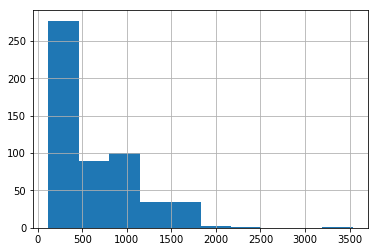

In [18]:
plans.groupby('study_id')['instance_uid'].count().hist()

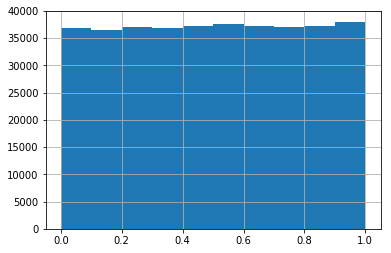

In [19]:
plans['z_level'].hist()

1197


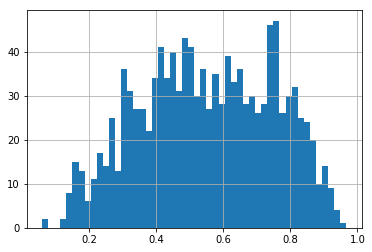

In [33]:
lung_plan_with_nodules = plans[plans['HasNodules'] & plans['IsLung']]['z_level']
print(len(lung_plan_with_nodules))
lung_plan_with_nodules.hist(bins=50)

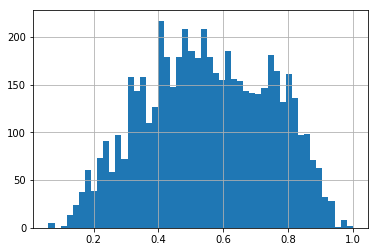

In [28]:
nodules['z_level'].hist(bins=50)

In [22]:
studies_to_exclude = studies_with_unknow_plan_type

In [23]:
studies = pd.DataFrame(data=protocols[~protocols['study_id'].isin(studies_to_exclude)]['study_id'].unique())
len(studies)

537

In [24]:
plans = plans[~plans['study_id'].isin(studies_to_exclude)]
len(plans)

364714

In [25]:
nodules = nodules[~without_plan_instance & ~nodules['study_id'].isin(studies_to_exclude)]
len(nodules[['study_id', 'nodule_id', 'z']].drop_duplicates())

4054

In [26]:
len(nodules)

5506

In [27]:
studies.to_csv('data/studies', index=False)
plans.to_csv('data/plans', index=False)
nodules.to_csv('data/nodules', index=False)